## TOC

- [Ta-feng dataset description](#Ta-feng-dataset)

- [Visualise the dataset](#Visualise-the-dataset)

- [Customers and transactions forecasting with EWMA](#Customers-and-transactions-prediction)

- [Seasonal product recommendation and Outlier detection](#Seasonal-product-recommendation-and-Outlier-detection)

- [Purchase prediction](#Purchase-prediction)

- [Product recommendation](#Product-recommendation)

In [109]:
import os

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import seaborn

In [4]:
%matplotlib inline

In [5]:
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)
plt.rc('figure', figsize=(18, 6))

In [6]:
os.chdir('../datasets/ta-feng/')

## Ta-feng dataset

http://recsyswiki.com/wiki/Grocery_shopping_datasets

http://www.bigdatalab.ac.cn/benchmark/bm/dd?data=Ta-Feng

#### It contains these files

D11: Transaction data collected in November, 2000

D12: Transaction data collected in December, 2000

D01: Transaction data collected in January, 2001

D02: Transaction data collected in February, 2001

#### Format of Transaction Data

First line: Column definition in Traditional Chinese

Second line and the rest: data columns separated by ";"

#### Column definition

Transaction date and time (time invalid and useless)

Customer ID

Age, 10 possible values: `A <25, B 25-29, C 30-34, D 35-39, E 40-44, F 45-49, G 50-54, H 55-59, I 60-64, J >65`

Residence Area, 8 possible values: A-F: zipcode area: 105,106,110,114,115,221, G: others, H: Unknown Distance to store.
(From the closest: 115,221,114,105,106,110)

Product subclass

Product ID

Amount

Asset

Sales price

In [82]:
header = [
    'day', 'customer_id', 'age_group', 'residence_area', 'product_subclass', 'product_id', 'amount', 'asset', 'sales_price'
]

In [83]:
full = pd.DataFrame(columns=header)

for fn in ['D01', 'D02', 'D11', 'D12']:
    full = pd.concat(
        [full, pd.read_csv(fn, sep=';', 
                           parse_dates=['day'], 
                           index_col=False, 
                           header=0, names=header)]  # overwrite the header
    )
    

In [9]:
full.head()

,day,customer_id,age_group,residence_area,product_subclass,product_id,amount,asset,sales_price
0,2001-01-01,141833,F,F,130207,4.710105e+12,2,44,52
1,2001-01-01,1376753,E,E,110217,4.710266e+12,1,150,129
2,2001-01-01,1603071,E,G,100201,4.712019e+12,1,35,39
3,2001-01-01,1738667,E,F,530105,4.710169e+12,1,94,119
4,2001-01-01,2141497,A,B,320407,4.710431e+12,1,100,159


## Visualise the dataset

Product sales distribution show a typical long-tail distribution

(0, 500)

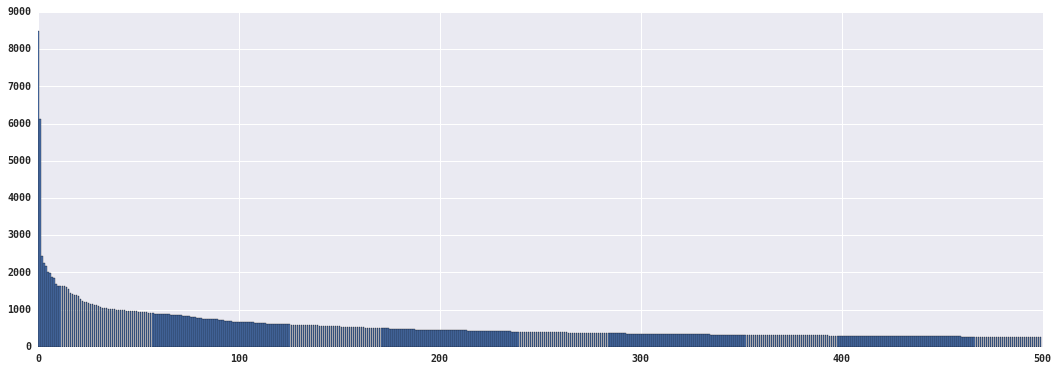

In [14]:
LIMIT = 500

vc = full['product_id'].value_counts().head(LIMIT)

lables = vc.index
indices = range(len(vc))
plt.bar(
    indices, vc.values, align='center'
)
plt.xlim(0, LIMIT)

Customers, transactions, and total sales per day

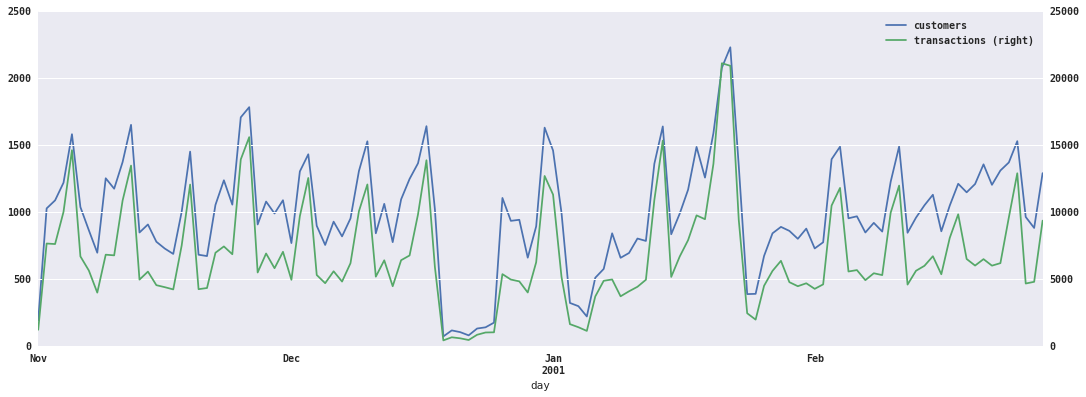

In [25]:
# customers by day
by_day = pd.DataFrame(
    [(day, len(data['customer_id'].value_counts())) for (day, data) in full.groupby('day')],
    columns=['day', 'customers']
)
# transactions by day
by_day['transactions'] = pd.Series(
    [len(data) for (day, data) in full.groupby('day')]
)
by_day.index = by_day['day']

plt.figure()
by_day['customers'].plot(legend=True)
by_day['transactions'].plot(secondary_y=True, legend=True)

Public holidays in the period:

- New year: 30/12/2000 - 1/1/2001

- Spring festival: 24/1 - 28/1/2001

Note:

- Some thing happened from 19/12 to 25/12/2000

- Spring festival increased sales

<Container object of 11 artists>

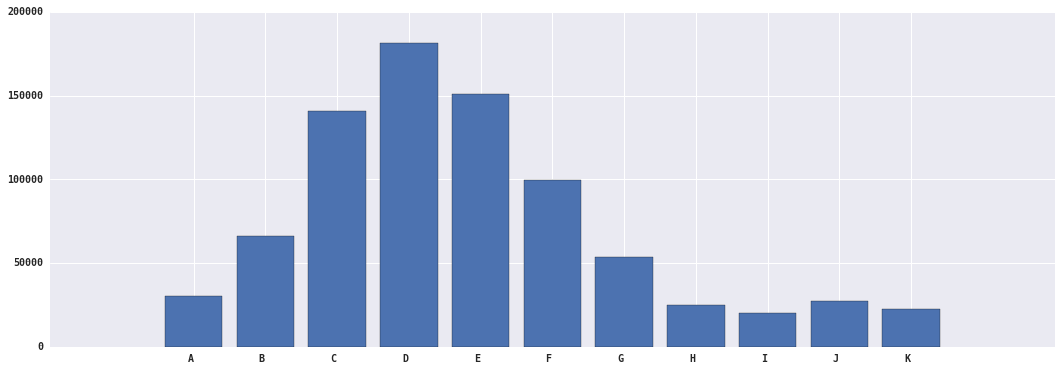

In [74]:
vc = full['age_group'].value_counts().sort_index()

plt.bar(
    range(len(vc.index)), vc.values, tick_label=vc.index, align='center'
)

<Container object of 8 artists>

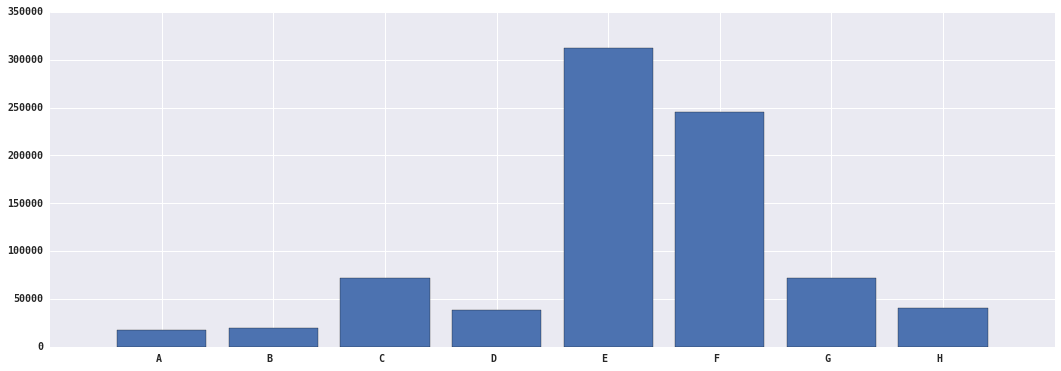

In [85]:
vc = full['residence_area'].value_counts().sort_index()

plt.bar(
    range(len(vc.index)), vc.values, tick_label=vc.index, align='center'
)

Note:

- `E` is the closest, then `F`
    
- `C` is the furthest 

Total sales amount

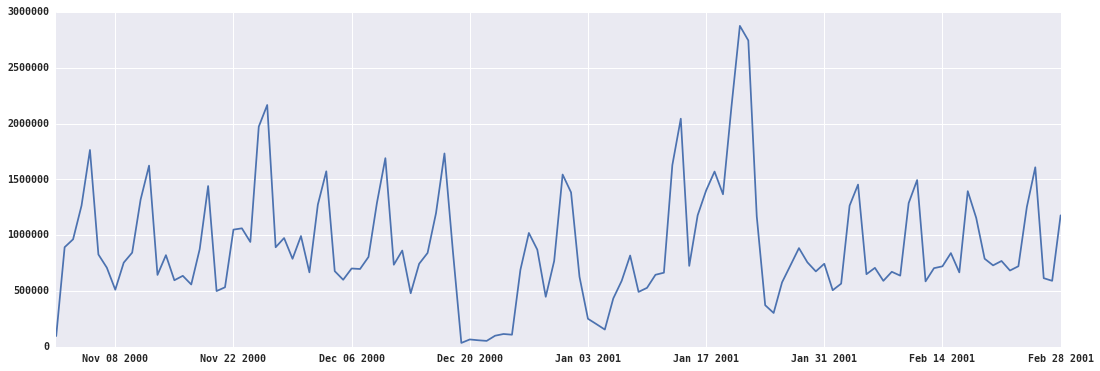

In [26]:
days = []
sales_prices = []

for day, data in full.groupby('day'):
    total_price = data.sum()['sales_price']
    
    days.append(day)
    sales_prices.append(total_price)

plt.plot(
    days, sales_prices
)

## Customers and transactions prediction

Exponentially-weighted moving average with correction

In [27]:
customers_by_day = pd.DataFrame(
    [(day, len(data['customer_id'].value_counts())) for (day, data) in full.groupby('day')],
    columns=['day', 'customers']
)

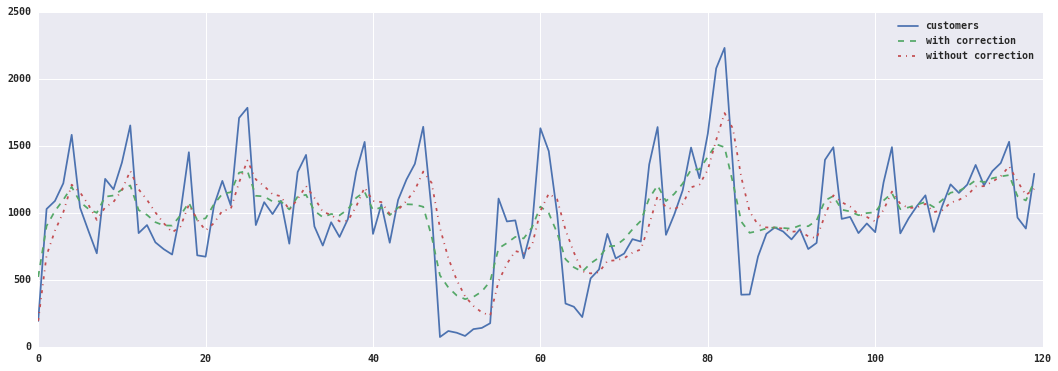

In [33]:
regular = pd.ewma(customers_by_day['customers'], halflife=2)
reverse = pd.ewma(customers_by_day['customers'][::-1], halflife=2)
# the regular EWMA is not good at predicting trends
# a shortcut is to average with the reverse series
average = (regular + reverse) / 2

indices = range(len(customers_by_day))
plt.plot(
    indices, customers_by_day['customers']
)
plt.plot(
    indices, average, '--', label='with correction'
)
plt.plot(
    indices, regular, '-.', label='without correction'
)
plt.legend()

Create features from `day`

In [34]:
customers_by_day['day_of_week'] = customers_by_day['day'].map(lambda day: day.dayofweek)
customers_by_day['week_of_year'] = customers_by_day['day'].map(lambda day: day.week)
customers_by_day['day_of_year'] = customers_by_day['day'].map(lambda day: day.dayofyear)

In [35]:
customers_by_day = pd.get_dummies(customers_by_day, columns=['day_of_week', 'week_of_year', 'day_of_year'])
customers_by_day['ewma'] = average.values
del customers_by_day['day']

Compare the predictions of models with/without EWMA

In [36]:
from sklearn import linear_model

In [39]:
SPLIT = int(len(customers_by_day) * .8)

for exclude in [
    ['customers'],
    ['customers', 'ewma']
]:
    X = customers_by_day[[col for col in customers_by_day.columns if col not in exclude]]
    Y = customers_by_day['customers']    

    train_x = X[:SPLIT]
    train_y = Y[:SPLIT]

    test_x = X[SPLIT:]
    test_y = Y[SPLIT:]
                         
    clf = linear_model.LinearRegression()

    clf.fit(
        train_x, train_y
    )

    print 'without EWMA: ' if 'ewma' in exclude else 'with EWMA:'
    print clf.score(test_x, test_y)
    print

with EWMA:
0.140768641498

without EWMA: 
-0.545319525643



still far from perfect (1.0) but great improvement with EWMA

## Seasonal product recommendation and Outlier detection

Popular items on the weekly basis

In [8]:
full['week'] = full['day'].map(
    lambda day: day.weekofyear
)

In [180]:
popular_product = {}

In [181]:
LIMIT = 100

In [182]:
for week in full['week'].value_counts().index:
    df = full[
        full['week'] == week
    ]
    for code, count in df['product_id'].value_counts().head(LIMIT).iteritems():  # result from value_counts() is sorted 
        try:
            popular_product[code].append(
                (week, count)
            )
        except KeyError:
            popular_product[code] = [
                (week, count)
            ]

Find the all-time common ones (appearing more than 8 weeks, about 50% of the period)

In [183]:
FREQ_THRESHOLD_MAX = 8

In [184]:
all_time_common_products = []

for code, data in popular_product.iteritems():
    if len(data) > FREQ_THRESHOLD_MAX:
        all_time_common_products.append(code)

Find the least common ones (appearing just 1 week)

In [185]:
FREQ_THRESHOLD_MIN = 1

In [186]:
least_common_products = []

for code, data in popular_product.iteritems():
    if len(data) == FREQ_THRESHOLD_MIN:
        least_common_products.append(code)

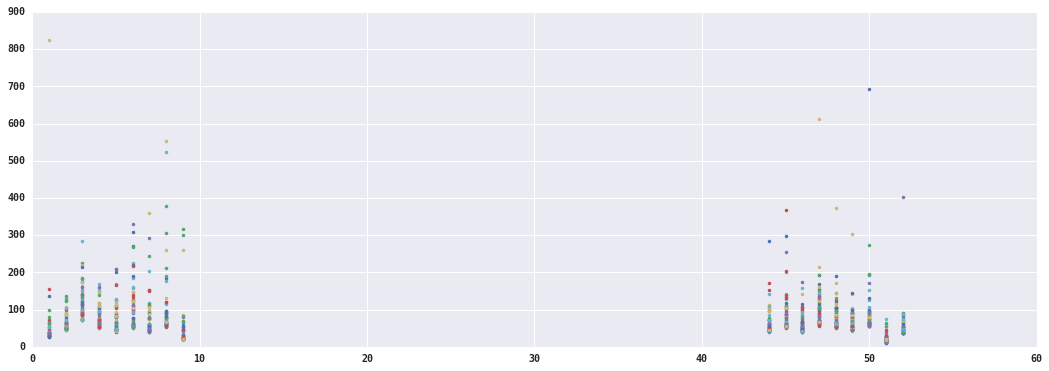

In [187]:
ax = plt.gca()

for code, data in popular_product.iteritems():
    if code not in all_time_common_products and code not in least_common_products:
        ax.plot(
            [it[0] for it in data],
            [it[1] for it in data],
            '.'
        )

### Outlier detection

PCA, then EllipticEnvelope and SVM

In [13]:
from scipy.sparse import csr_matrix

from sklearn import svm, decomposition, covariance

In [9]:
full['day_of_year'] = full['day'].map(
    lambda x: x.dayofyear
)

In [10]:
full.head()

,day,customer_id,age_group,residence_area,product_subclass,product_id,amount,asset,sales_price,week,day_of_year
0,2000-11-01,46855,D,E,110411,4.710085e+12,3,51,57,44,306
1,2000-11-01,539166,E,E,130315,4.714981e+12,2,56,48,44,306
2,2000-11-01,663373,F,E,110217,4.710266e+12,1,180,135,44,306
3,2000-11-01,340625,A,E,110411,4.710085e+12,1,17,24,44,306
4,2000-11-01,236645,D,H,712901,8.999003e+12,2,128,170,44,306


Conver the appearance of product_id into a matrix

In [11]:
y = []
x = []

for product_id, data in full.groupby('product_id'):
    y.append(product_id)
    x.append(
        data['day_of_year'].values
    )

Use sparse matrix for the ease of initialisation

In [14]:
idx_row = []
idx_column = []

for idx in x:
    idx_row.extend(
        [len(idx_row) for _ in idx]
    )
    idx_column.extend(
        idx
    )
    
matrix_x = csr_matrix(
    (np.ones(len(idx_row)), (idx_row, idx_column))
)    

dense_x = matrix_x.toarray()  # PCA requires a dense matrix

In [18]:
pca = decomposition.PCA(n_components=2)  # high dimension outlier detection is not trivial
pca_x = pca.fit_transform(dense_x)

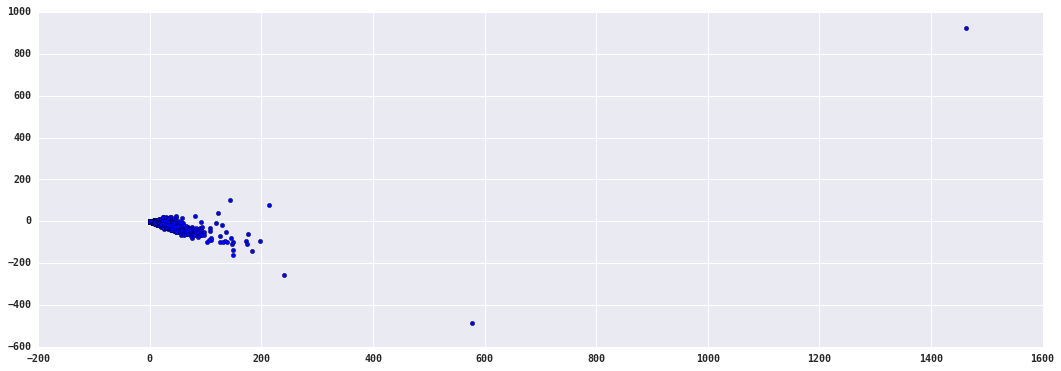

In [23]:
plt.scatter(
    [it[0] for it in pca_x],
    [it[1] for it in pca_x],
)

Try `EllipticEnvelope` and `OneClassSVM`, with evaluation and viz

#### OneClassSVM

In [ ]:
clf = svm.OneClassSVM()
clf.fit(pca_x)

# OneClassSVM is really a novelty detection algorithm that requires 'pure' training data

In [32]:
clf.get_params()

{'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'nu': 0.5,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [33]:
xx, yy = np.meshgrid(np.linspace(-200, 1600, 500), np.linspace(-600, 1000, 500))

In [ ]:
Z = clf.decision_function(np.c_[
        xx.ravel(), yy.ravel()
    ]).reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0])

# takes too long to compute the frontier, skipped

#### EllipticEnvelope

In [ ]:
clf = covariance.EllipticEnvelope()
clf.fit(pca_x)

# always gives: 
# ValueError: Singular covariance matrix.
# otherwise should be more robust given the amount of the data

In [ ]:
Z = clf.decision_function(np.c_[
        xx.ravel(), yy.ravel()
    ]).reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0])

# cannot create the model, skipped

### Purchase prediction

The goal is to build a purchase prediction engine.

The dataset only contains positive samples. We could randomly generate the same number of negative samples (not bought). We want to make sure that for each customer, we have a balanced dataset.

In [110]:
from functools import partial
from rosetta.parallel.parallel_easy import imap_easy

import itertools

In [111]:
N_JOBS = 8  # 8 cores

In [112]:
CHUNKSIZE = int(len(full) / N_JOBS)  # evenly distribute data among cores

In [30]:
def merge_customer_columns(data):
    idx, row = data
    return '{:.0f}_{}_{}'.format(row['customer_id'], row['age_group'].strip(), row['residence_area'].strip())

def merge_product_columns(data):
    idx, row = data
    return '{:.0f}_{:.0f}_{:.0f}_{:.0f}'.format(
        row['product_subclass'], row['product_id'], row['asset'] / row['amount'], row['sales_price'] / row['amount']
    )

full['customer'] = pd.Series(
    imap_easy(
        # ordered=False to avoid extra shuffle 
        partial(merge_customer_columns), full.iterrows(), n_jobs=N_JOBS, chunksize=CHUNKSIZE, ordered=False  
    )
)

full['product'] = pd.Series(
    imap_easy(
        partial(merge_product_columns), full.iterrows(), n_jobs=N_JOBS, chunksize=CHUNKSIZE, ordered=False
    )
)

In [17]:
days = full['day'].value_counts().index
products = full['product'].value_counts().index

In [18]:
def get_a_random_row():
    return np.random.choice(days), np.random.choice(products)

In [35]:
# the usage of `full` stops here. persist for easier access in future
full.to_csv('full_product_customer_merged.csv', index=False)  

Positive samples, Ravel `amount` to multiple rows

In [41]:
def ravel_amount(data):
    idx, row = data
    return [
        {'day': row['day'], 'product': row['product'], 'customer': row['customer'], 'buy': 1} 
        for _ in range(int(row['amount'])-1)
    ]

In [55]:
flat_full = pd.DataFrame(
    # DataFrame doesn't allow passing in a generator
    # this may not fit into the memory for larger datasets
    list(itertools.chain.from_iterable(imap_easy(
        partial(ravel_amount), full.iterrows(), n_jobs=N_JOBS, chunksize=CHUNKSIZE, ordered=False
    )))
)

Negative samples (ignore the case that we randomly generate a positive sample)

In [47]:
def generate_negative_samples_for_customer(data):
    customer, row = data
    ret = []
    # generate the same amount of negative samples as positive ones
    # don't iterate over row directly --- that will iterate columns, not rows
    for _ in range(len(row)):  
        day, product = get_a_random_row()
        ret.append({'day': day, 'product': product, 'customer': customer, 'buy': 0})
    return ret

In [48]:
flat_full = pd.concat([
    flat_full, pd.DataFrame(
        list(itertools.chain.from_iterable(
            imap_easy(generate_negative_samples_for_customer, flat_full.groupby('customer'), n_jobs=N_JOBS, chunksize=CHUNKSIZE)
        ))
    )
], axis=0)

In [49]:
flat_full['buy'].value_counts()  # make sure the balance

1    312198
0    312198
Name: buy, dtype: int64

Split so we can build features

In [ ]:
CHUNKSIZE = int(len(flat_full) / N_JOBS)

In [62]:
def split_and_get(data, idx, sep='_'):
    return data[1].split(sep)[idx]        

for idx, key in enumerate(['product_subclass', 'product_id', 'asset', 'sales_price']):
    flat_full[key] = pd.Series(
        imap_easy(partial(split_and_get, idx=idx), flat_full['product'].iteritems(), N_JOBS, CHUNKSIZE)
    )
    
for idx, key in enumerate(['customer_id', 'age_group', 'residence_area']):
    flat_full[key] = pd.Series(
        imap_easy(partial(split_and_get, idx=idx), flat_full['customer'].iteritems(), N_JOBS, CHUNKSIZE)
    )


Basic transformation on `day` only

In [51]:
# should be fast enough, skip the parallelism

flat_full['week_of_year'] = flat_full['day'].map(lambda x: x.week)
flat_full['day_of_week'] = flat_full['day'].map(lambda x: x.dayofweek)
flat_full['day_of_year'] = flat_full['day'].map(lambda x: x.dayofyear)

In [52]:
flat_full.to_csv('flat_full_with_basic_transformation.csv', index=False)

Build features

In [33]:
from sklearn.feature_extraction import DictVectorizer

In [34]:
enc = DictVectorizer()

In [53]:
# be specific about features if possible

feature_columns = [
    'customer',  # keep the 2nd level features
    'customer_id', 'age_group', 'residence_area',
    'product',
    'product_subclass', 'product_id', 'asset', 'sales_price',
    'week_of_year', 'day_of_week', 'day_of_year', 'day'
]

In [ ]:
x = enc.fit_transform(flat_full[feature_columns].to_dict(orient='records'))

In [57]:
feature_names = enc.get_feature_names()

In [58]:
y = flat_full['buy'].values

#### Simple test on shuffles

In [77]:
# use a few basic models to demonstrate the idea
# cv need to be added

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

In [78]:
x, y = shuffle(x, y)

In [79]:
SPLIT = int(x.shape[0] * .8)

train_x = x[:SPLIT]
train_y = y[:SPLIT]

test_x = x[SPLIT:]
test_y = y[SPLIT:]

In [80]:
for name, clf in [
    ('LogisticRegression', LogisticRegression()),
    ('Lasso', Lasso()),
    ('RandomForest', RandomForestClassifier())
]:
    
    
    clf.fit(train_x, train_y)
    
    print name
    print clf.score(test_x, test_y)
    print

LogisticRegression
0.499423446509

Lasso
-2.69107928563e-06

RandomForest
0.406726457399



### Product recommendation

User based

In [101]:
customer_bought_products = full[['customer_id', 'product_id', 'amount']]

Ignore the recency and aggregate the purchase history

In [103]:
aggregated = customer_bought_products.groupby(['customer_id', 'product_id']).sum()

In [107]:
aggregated.reset_index(inplace=True)

In [113]:
def concat_product_amount(data):
    idx, row = data
    return '{:.0f}_{:.0f}'.format(row['product_id'], row['amount'])

aggregated['product_amount'] = pd.Series(
    imap_easy(concat_product_amount, aggregated[['product_id', 'amount']].iterrows(), N_JOBS, CHUNKSIZE)
)

In [115]:
del aggregated['product_id']
del aggregated['amount']

In [117]:
aggregated.head()

,customer_id,product_amount
0,1069,22000167620_2
1,1069,4710011402026_2
2,1069,4710022101208_1
3,1069,4710088620156_2
4,1069,4710176008699_2


Build user vectors

In [128]:
enc = DictVectorizer()

In [140]:
x = enc.fit_transform(aggregated[['product_amount', ]].to_dict(orient='record'))

In [141]:
feature_names = enc.get_feature_names()

In [ ]:
x = pd.SparseDataFrame(
    [pd.SparseSeries(x[idx].toarray().ravel()) for idx in np.arange(x.shape[0])],
    columns=feature_names
)

In [146]:
x['customer_id'] = aggregated['customer_id']

<743228x57913 sparse matrix of type '<type 'numpy.float64'>'
	with 743228 stored elements in Compressed Sparse Row format>

In [ ]:
x = x.groupby('customer_id').sum()

Build NearestNeighbors model

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
nbrs = NearestNeighbors(n_neighbors=4).fit(x)

Query the model, take average as recommendations